## Домашняя работа 4.

Максимальный балл за задание - 10.

## Данные


В этой домашней работе мы будем обучать модели машинного обучения, ставить эксперименты, подбирать гиперпараметры, сравнивать и смешивать модели. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week

Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

## Метрика качества

В задании мы будем оценивать качество моделей с помощью метрики AUC-ROC.

## Подбор гиперпараметров модели

В задачах машинного обучения следует различать параметры модели и гиперпараметры (структурные параметры). Обычно параметры модели настраиваются в ходе обучения (например, веса в линейной модели или структура решающего дерева), в то время как гиперпараметры задаются заранее (например, регуляризация в линейной модели или максимальная глубина решающего дерева). Каждая модель обычно имеет множество гиперпараметров, и нет универсальных наборов гиперпараметров, оптимально работающих во всех задачах, для каждой задачи нужно подбирать свой набор.

Для оптимизации гиперпараметров модели часто используют _перебор по сетке (grid search)_: для каждого гиперпараметра выбирается несколько значений, перебираются все комбинации значений и выбирается комбинация, на которой модель показывает лучшее качество (с точки зрения метрики, которая оптимизируется). Однако в этом случае нужно грамотно оценивать построенную модель, а именно делать разбиение на обучающую и тестовую выборку. Есть несколько схем, как это можно реализовать:

 - Разбить имеющуюся выборку на обучающую и тестовую. В этом случае сравнение большого числа моделей при переборе параметров приводит к ситуации, когда лучшая на тестовой подвыборке модель не сохраняет свои качества на новых данных. Можно сказать, что происходит _переобучение_ на тестовую выборку.
 - Для устранения описанной выше проблемы, можно разбить данные на 3 непересекающихся подвыборки: обучение (`train`), валидация (`validation`) и контроль (`test`). Валидационную подвыборку используют для сравнения моделей, а `test` — для окончательной оценки качества и сравнения семейств моделей с подобранными параметрами.
 - Другой способ сравнения моделей — [кросс-валидация](http://en.wikipedia.org/wiki/Cross-validation_(statistics). Существуют различные схемы кросс-валидации:
  - Leave-One-Out
  - K-Fold
  - Многократное случайное разбиение выборки
  
Кросс-валидация вычислительно затратна, особенно если вы делаете перебор по сетке с очень большим числом комбинации. С учетом конечности времени на выполнение задания, возникает ряд компромиссов:
  - сетку можно делать более разреженной, перебирая меньше значений каждого параметра; однако, надо не забывать, что в таком случае можно пропустить хорошую комбинацию параметров;
  - кросс-валидацию можно делать с меньшим числом разбиений или фолдов, но в таком случае оценка качества кросс-валидации становится более шумной и увеличивается риск выбрать неоптимальный набор параметров из-за случайности разбиения;
  - параметры можно оптимизировать последовательно (жадно) — один за другим, а не перебирать все комбинации; такая стратегия не всегда приводит к оптимальному набору;
  - перебирать не все комбинации параметров, а небольшое число случайно выбранных.

## Задание

Загрузите набор данных *data.adult.csv*. Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [ ]:
!pip install category_encoders

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, mean_squared_error, r2_score, roc_auc_score, classification_report, recall_score
from sklearn.metrics import roc_curve, auc, precision_score
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
mpl.style.use('seaborn') # так красивее

import random
random.seed(911)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
data = pd.read_csv("data.adult.csv")
data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,25,Local-gov,514716,Bachelors,13,Never-married,Adm-clerical,Own-child,Black,Female,0,0,40,<=50K
16276,32,Private,207668,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,15024,0,45,>50K
16277,27,Private,104457,Bachelors,13,Never-married,Machine-op-inspct,Not-in-family,Asian-Pac-Islander,Male,0,0,40,<=50K
16278,59,State-gov,268700,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,<=50K


In [ ]:
data.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
>50K,<=50K        object
dtype: object

In [ ]:
data.shape

(16280, 14)

Иногда в данных встречаются пропуски. Как задаются пропуски обычно либо прописывается в описании к данным, либо просто на месте пропуска после чтения данных оказывается значение numpy.nan. Более подробно о работе с пропусками в Pandas можно прочитать например [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html).

В данном датасете пропущенные значения обозначены как "?".

**Задание 1 (0.5 балла)** Найдите все признаки, имеющие пропущенные значения. Удалите из выборки все объекты с пропусками.

In [ ]:
data.isnull().sum() # только для пропусков, не для '?'

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
>50K,<=50K        0
dtype: int64

In [ ]:
data= data.replace("?", pd.NA)
data.isna().sum()
# 923 и 933 пропущенных у workclass и occupation

age                 0
workclass         929
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        933
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
>50K,<=50K          0
dtype: int64

In [ ]:
data = data.dropna()
print(data.shape)

(15347, 14)


Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем:

 - Выделите целевую переменную в отдельную переменную, удалите ее из датасета и преобразуйте к бинарному формату.
 - Обратите внимание, что не все признаки являются вещественными. В начале мы будем работать только с вещественными признаками. Выделите их отдельно.

In [ ]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K


In [ ]:
X = data.drop(">50K,<=50K", axis=1)
y = data['>50K,<=50K']
print(X.shape, y.shape)
print(y.unique())
y[y == '>50K'] = 1
y[y == '<=50K'] = 0
print(y.unique())
y = y.astype(int)
data['>50K,<=50K'] = data['>50K,<=50K'].astype(int)
print(y.value_counts(normalize=True)) #unbalansed

(15347, 13) (15347,)
['<=50K' '>50K']
[0 1]
0    0.743272
1    0.256728
Name: >50K,<=50K, dtype: float64


In [ ]:
data.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
>50K,<=50K         int64
dtype: object

In [ ]:
num_cols = X.columns[X.dtypes == 'int64'].tolist()
cat_cols = X.columns[X.dtypes == 'object']
print(f'Мы имеем {len(num_cols)} числовых признаков: {", ".join(num_cols)}.')
print(f'Также у нас есть {len(cat_cols)} категориальных признаков: {", ".join(cat_cols)}.')

Мы имеем 6 числовых признаков: age, fnlwgt, education-num, capital-gain, capital-loss, hours-per-week.
Также у нас есть 7 категориальных признаков: workclass, education, marital-status, occupation, relationship, race, sex.


In [ ]:
X_vesch = X[num_cols]
X_vesch.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,34,284843,9,594,0,60
1,40,190290,10,0,0,40
2,36,177858,13,0,0,40
3,22,184756,10,0,0,30
4,47,149700,13,15024,0,40


## Обучение классификаторов на вещественных признаках

В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

В начале посмотрим как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 5 алгоритмов:
 - [kNN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [SGD Linear Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
 - [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
 - [GradientBoosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

Для начала у первых трёх алгоритмов выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - DecisonTree — глубина дерева (*max_depth*)
 - SGD Linear Classifier — оптимизируемая функция (*loss*)

Остальные параметры оставляйте в значениях по умолчанию. Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). В качестве схемы кросс-валидации используйте 5-fold cv, которую можно задать с помощью класса [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

**Задание 2 (1 балл)** Для каждого из первых трех алгоритмов подберите оптимальные значения указанных гиперпараметров. Для каждого из этих алгоритмов постройте график среднего качества по кросс-валидации при заданном значении гиперпараметра, на котором также отобразите доверительный интервал [m-std, m+std], где m - среднее, std - стандартное отклонение.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 8)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_vesch, y, test_size=0.3, random_state=1337)

In [ ]:
kNN_class_pipe = Pipeline([(
    'kNN_class', KNeighborsClassifier()
)])

params_kNN_class = {
    'kNN_class__n_neighbors': np.arange(1, 21, 1)
}

DecisionTree_class_pipe = Pipeline([(
    'DecisonTree_class', DecisionTreeClassifier()
)])

params_DecisionTree_class = {
    'DecisonTree_class__max_depth': np.arange(1, 16, 1)
}

SGD_class_pipe = Pipeline([(
    'SGD_class', SGDClassifier()
)])

params_SGD_class = {
    'SGD_class__loss': ['hinge', 'log', 'modified_huber',
    'squared_hinge', 'perceptron']
}

grid_kNN_class = GridSearchCV(
    kNN_class_pipe,
    params_kNN_class,
    cv=5,
    scoring='roc_auc'
)
grid_kNN_class.fit(X_train, y_train)
print(f'kNN ROC_AUC: {roc_auc_score(y_test, grid_kNN_class.predict(X_test))}')
print(f'Используемые гиперпараметры: {grid_kNN_class.best_params_}')

grid_DecisionTree_class = GridSearchCV(
    DecisionTree_class_pipe,
    params_DecisionTree_class,
    cv=5,
    scoring='roc_auc'
)
grid_DecisionTree_class.fit(X_train, y_train)
print(f'Decision Tree ROC_AUC: {roc_auc_score(y_test, grid_DecisionTree_class.predict(X_test))}')
print(f'Используемые гиперпараметры: {grid_DecisionTree_class.best_params_}')

grid_SGD_class = GridSearchCV(
    SGD_class_pipe,
    params_SGD_class,
    cv=5,
    scoring='roc_auc'
)
grid_SGD_class.fit(X_train, y_train)
print(f'SGD ROC_AUC: {roc_auc_score(y_test, grid_SGD_class.predict(X_test))}')
print(f'Используемые гиперпараметры: {grid_SGD_class.best_params_}')

kNN ROC_AUC: 0.5905420815595308
Используемые гиперпараметры: {'kNN_class__n_neighbors': 8}
Decision Tree ROC_AUC: 0.7024624994251754
Используемые гиперпараметры: {'DecisonTree_class__max_depth': 7}
SGD ROC_AUC: 0.5
Используемые гиперпараметры: {'SGD_class__loss': 'perceptron'}


In [ ]:
grid_kNN_class.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_kNN_class__n_neighbors', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

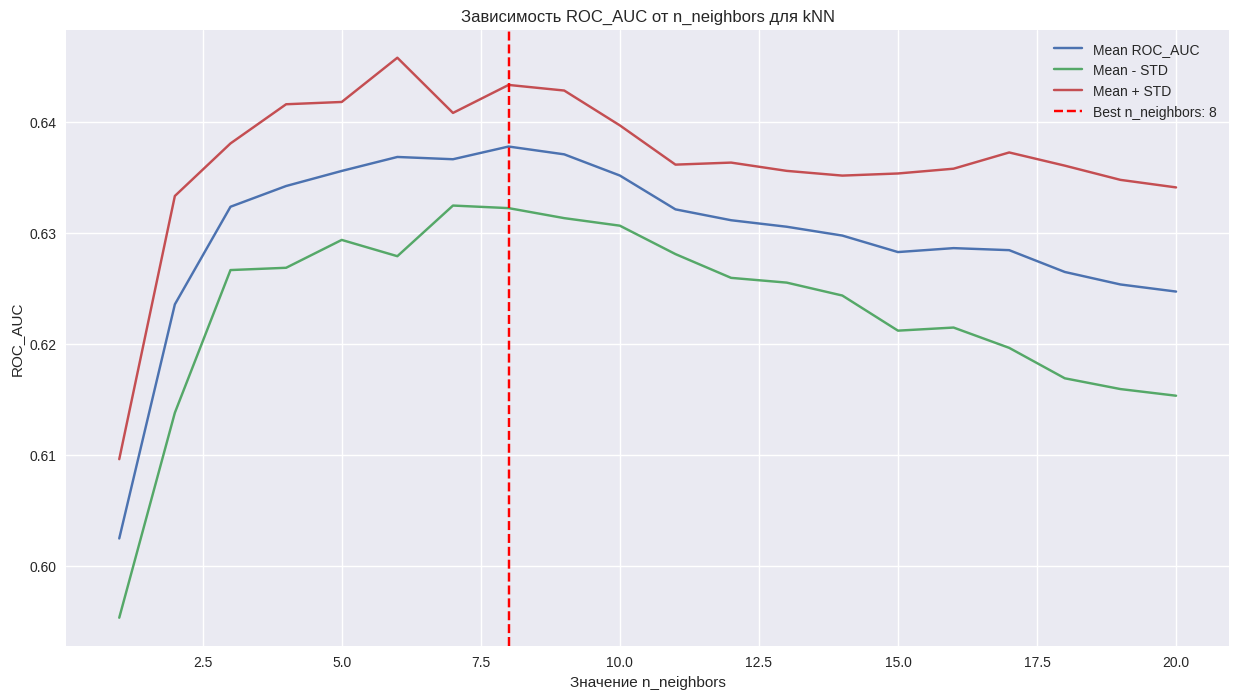

In [ ]:
n_neighbors_range = params_kNN_class['kNN_class__n_neighbors']  # Диапазон значений n_neighbors
mean_scores = grid_kNN_class.cv_results_['mean_test_score']
std_scores = grid_kNN_class.cv_results_['std_test_score']
# mean - std и mean + std
mean_minus_std = mean_scores - std_scores
mean_plus_std = mean_scores + std_scores
plt.plot(n_neighbors_range, mean_scores, label='Mean ROC_AUC')
plt.plot(n_neighbors_range, mean_minus_std, label='Mean - STD')
plt.plot(n_neighbors_range, mean_plus_std, label='Mean + STD')
best_n_neighbors = grid_kNN_class.best_params_['kNN_class__n_neighbors']
plt.axvline(x=best_n_neighbors, color='r', linestyle='--', label=f'Best n_neighbors: {best_n_neighbors}')
plt.title("Зависимость ROC_AUC от n_neighbors для kNN")
plt.xlabel("Значение n_neighbors")
plt.ylabel("ROC_AUC")
plt.legend()
plt.show()


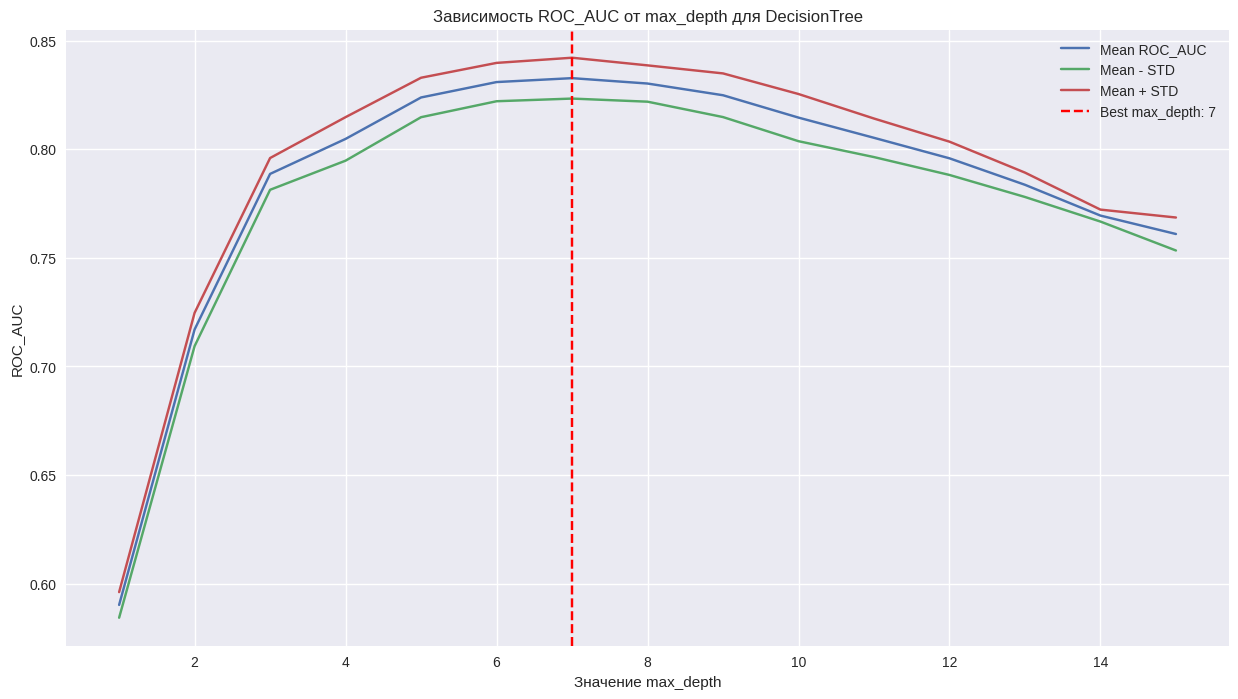

In [ ]:
max_depth_range = params_DecisionTree_class['DecisonTree_class__max_depth']  # Диапазон значений n_neighbors
mean_scores = grid_DecisionTree_class.cv_results_['mean_test_score']
std_scores = grid_DecisionTree_class.cv_results_['std_test_score']
# mean - std и mean + std
mean_minus_std = mean_scores - std_scores
mean_plus_std = mean_scores + std_scores
plt.plot(max_depth_range, mean_scores, label='Mean ROC_AUC')
plt.plot(max_depth_range, mean_minus_std, label='Mean - STD')
plt.plot(max_depth_range, mean_plus_std, label='Mean + STD')
best_max_depth = grid_DecisionTree_class.best_params_['DecisonTree_class__max_depth']
plt.axvline(x=best_max_depth, color='r', linestyle='--', label=f'Best max_depth: {best_max_depth}')
plt.title("Зависимость ROC_AUC от max_depth для DecisionTree")
plt.xlabel("Значение max_depth")
plt.ylabel("ROC_AUC")
plt.legend()
plt.show()

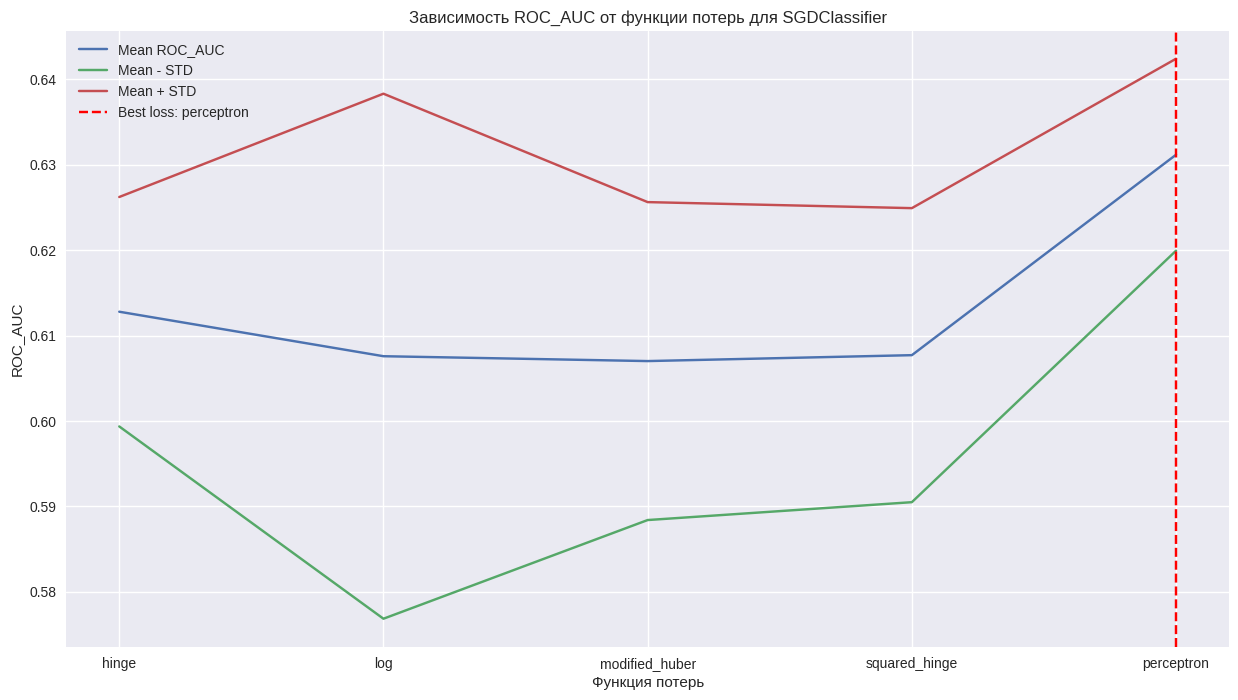

In [ ]:
loss_functions = ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']

#mean - std и mean + std
mean_minus_std = grid_SGD_class.cv_results_['mean_test_score'] - grid_SGD_class.cv_results_['std_test_score']
mean_plus_std = grid_SGD_class.cv_results_['mean_test_score'] + grid_SGD_class.cv_results_['std_test_score']

plt.plot(loss_functions, grid_SGD_class.cv_results_['mean_test_score'], label='Mean ROC_AUC')
plt.plot(loss_functions, mean_minus_std, label='Mean - STD')
plt.plot(loss_functions, mean_plus_std, label='Mean + STD')
best_loss = grid_SGD_class.best_params_['SGD_class__loss']
best_loss_index = loss_functions.index(best_loss)
plt.axvline(x=best_loss_index, color='r', linestyle='--', label=f'Best loss: {best_loss}')
plt.title("Зависимость ROC_AUC от функции потерь для SGDClassifier")
plt.xlabel("Функция потерь")
plt.ylabel("ROC_AUC")
plt.xticks(range(len(loss_functions)), loss_functions)
plt.legend()
plt.grid(True)
plt.show()


у kNN и SGD высокая диспресия и более низкое значение метрики, поэтому лучшей моделькой в данном случае является **DecisionTree**

Что вы можете сказать о получившихся графиках?

**Задание 3 (0.5 балла)** Также подберём число деревьев (*n_estimators*) в алгоритме RandomForest. Как известно, в общем случае Random Forest не переобучается с увеличением количества деревьев, так что при увеличении этого гиперпараметра его качество не будет становиться хуже. Поэтому подберите такое количество деревьев, при котором качество на кросс-валидации стабилизируется. Обратите внимание, что для проведения этого эксперимента не нужно с нуля обучать много случайных лесов с различными количествами деревьев. Обучите один случайный лес с максимальным интересным количеством деревьев, а затем рассмотрите подмножества разных размеров, состоящие из деревьев построенного леса (поле [*estimators_*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). В дальнейших экспериментах используйте это количество деревьев.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RandomForest_class_pipe = Pipeline([('RandomForest_class', RandomForestClassifier())])
params_RandomForest_class = {
    'RandomForest_class__n_estimators': np.arange(1, 50, 1)
}
grid_RandomForest_class = GridSearchCV(RandomForest_class_pipe, params_RandomForest_class, cv=5, scoring='roc_auc')
grid_RandomForest_class.fit(X_train, y_train)
print(f'RandomForest ROC_AUC: {roc_auc_score(y_test, grid_RandomForest_class.predict(X_test))}')
print(f'Используемые гиперпараметры: {grid_RandomForest_class.best_params_}')

RandomForest ROC_AUC: 0.6961541058127236
Используемые гиперпараметры: {'RandomForest_class__n_estimators': 44}


**Задание 4 (0.5 балла)** Подберём число деревьев (*n_estimators*) в алгоритме GradientBoosting. Мы знаем, что ошибка бустинга на тестовых данных, как правило, имеет U-образную форму, то есть сначала уменьшается, а при достижении некоторого числа деревьев начинает расти. Нарисуйте график ошибки в зависимости от числа деревьев. Подберите n_estimators, соответствующий минимуму ошибки.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

GradientBoosting_class_pipe = Pipeline([(
    'GradientBoosting_class', GradientBoostingClassifier()
)])
params_GradientBoosting_class = {
    "GradientBoosting_class__n_estimators": np.arange(1, 50, 1)
}

grid_gradboost = GridSearchCV(
    GradientBoosting_class_pipe,
    params_GradientBoosting_class,
    cv=5,
    scoring='roc_auc'
)
grid_gradboost.fit(X_train, y_train)
print(f'GradientBoosting ROC_AUC: {roc_auc_score(y_test, grid_gradboost.predict(X_test))}')
print(f'Используемые гиперпараметры: {grid_gradboost.best_params_}')

GradientBoosting ROC_AUC: 0.7017993720469918
Используемые гиперпараметры: {'GradientBoosting_class__n_estimators': 49}


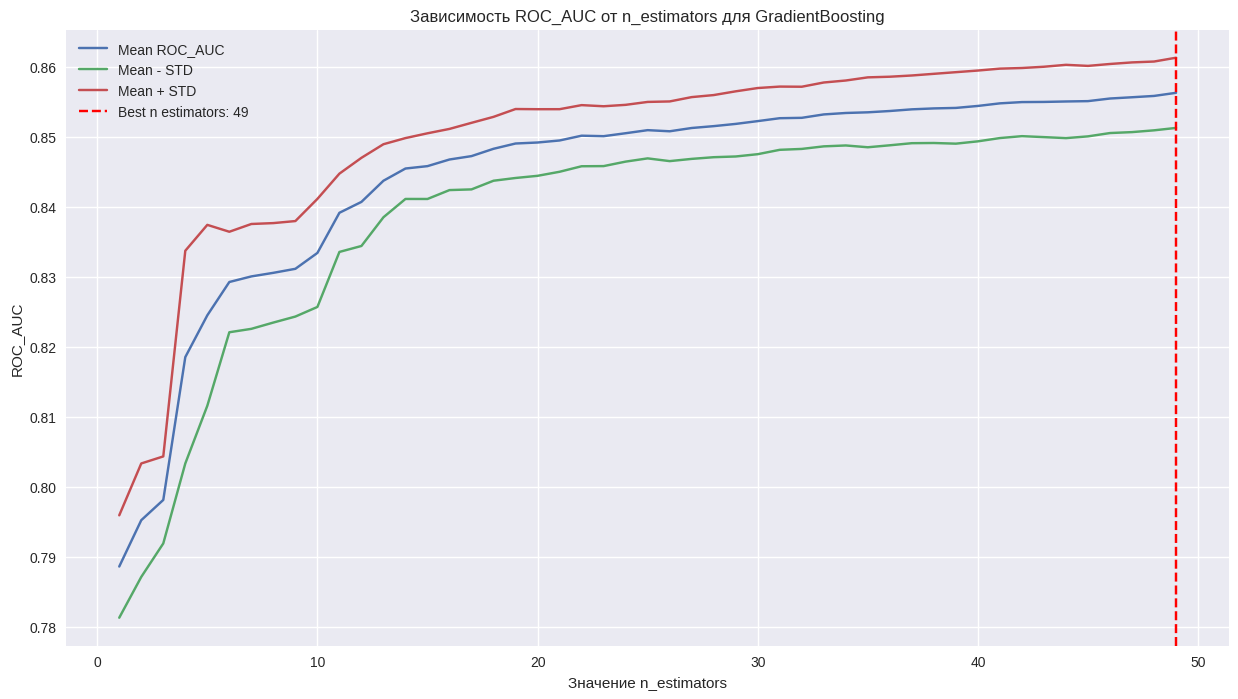

In [ ]:
max_n__esimators = params_GradientBoosting_class['GradientBoosting_class__n_estimators']
mean_scores = grid_gradboost.cv_results_['mean_test_score']
std_scores = grid_gradboost.cv_results_['std_test_score']
# mean - std и mean + std
mean_minus_std = mean_scores - std_scores
mean_plus_std = mean_scores + std_scores
plt.plot(max_n__esimators, mean_scores, label='Mean ROC_AUC')
plt.plot(max_n__esimators, mean_minus_std, label='Mean - STD')
plt.plot(max_n__esimators, mean_plus_std, label='Mean + STD')
best_max_n = grid_gradboost.best_params_['GradientBoosting_class__n_estimators']
plt.axvline(x=best_max_n, color='r', linestyle='--', label=f'Best n estimators: {best_max_n}')
plt.title("Зависимость ROC_AUC от n_estimators для GradientBoosting")
plt.xlabel("Значение n_estimators")
plt.ylabel("ROC_AUC")
plt.legend()
plt.show()

При обучении алгоритмов стоит обращать внимание не только на качество, но и каким образом они работают с данными. В этой задаче получилось так, что некоторые из используемых алгоритмов чувствительны к масштабу признаков. Чтобы убедиться, что это как-то могло повлиять на качество давайте посмотрим на сами признаки.

**Задание 5 (0.5 балла)** Постройте гистограммы для признаков *age*, *fnlwgt*, *capital-gain*. Глядя на получившиеся графики в чем заключается особенность данных? На какие алгоритмы это может повлиять? Может ли масшитабирование повлиять на работу этих алгоритмов?

Text(0, 0.5, 'Частота')

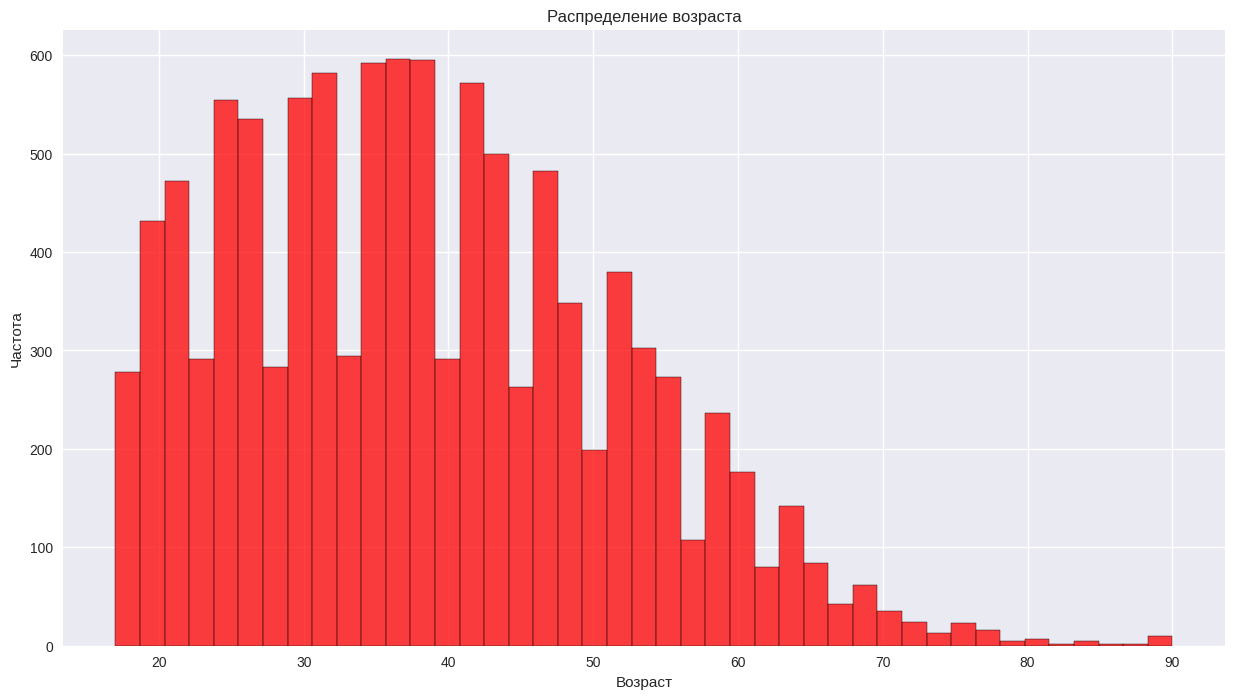

In [ ]:
sns_plot = sns.histplot(X_train['age'], color='red', kde=False)
sns_plot.set_title('Распределение возраста')
sns_plot.set_xlabel('Возраст')
sns_plot.set_ylabel('Частота')

Text(0, 0.5, 'Частота')

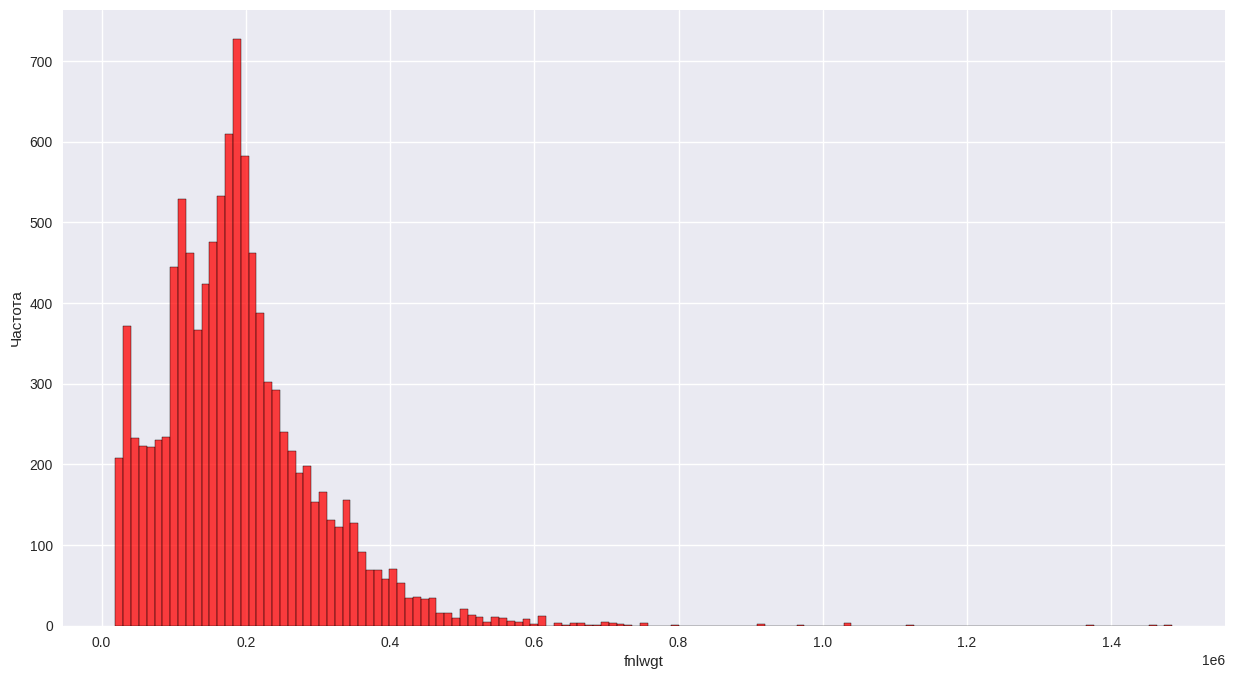

In [ ]:
sns_plot = sns.histplot(X_train['fnlwgt'], color='red', kde=False)
sns_plot.set_ylabel('Частота')

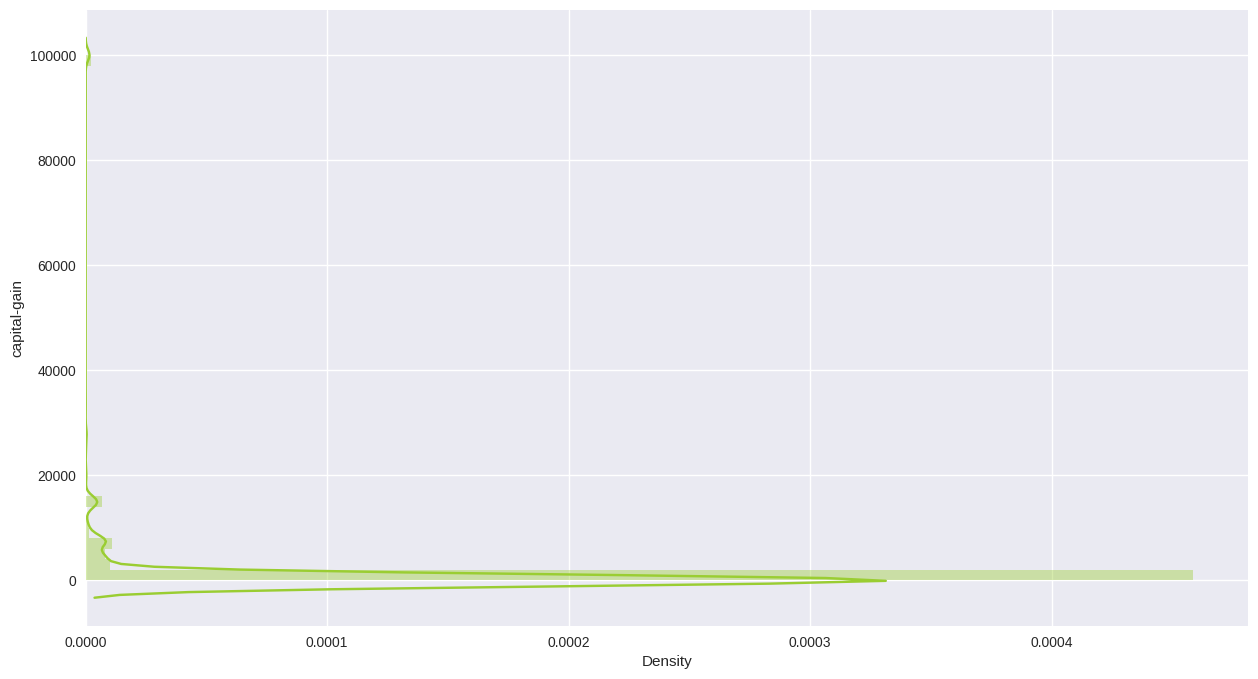

In [ ]:
sns_plot = sns.distplot(X_train['capital-gain'], color='yellowgreen', vertical=True, norm_hist=False)
fig = sns_plot.get_figure()

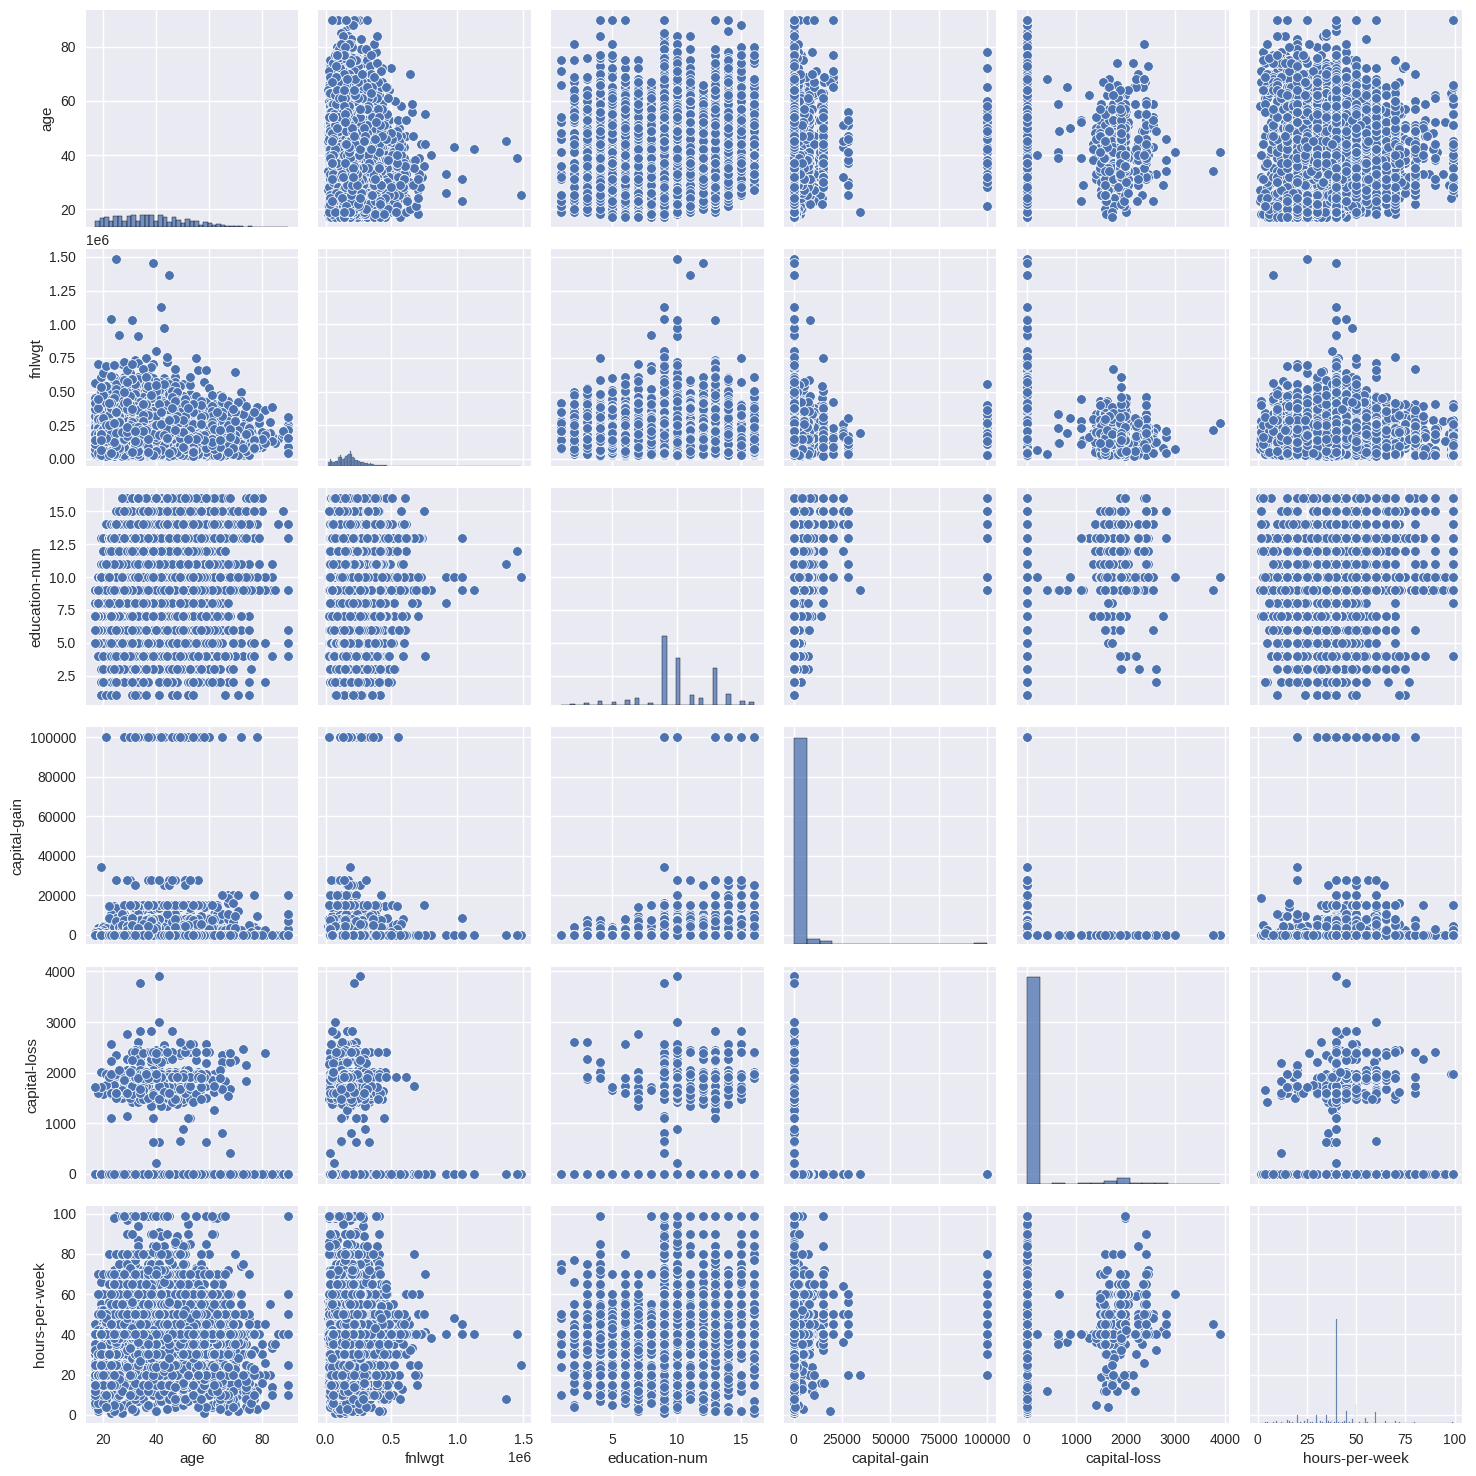

In [ ]:
sns.pairplot(X_train)

данные очень разноразмерные по масштабу и плотности. Есть большие скопления данных, а где то их мало

Масштабирование признаков можно выполнить, например, одним из следующих способов способами:
 - $x_{new} = \dfrac{x - \mu}{\sigma}$, где $\mu, \sigma$ — среднее и стандартное отклонение значения признака по всей выборке (см. функцию [scale](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html))
 - $x_{new} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$, где $[x_{min}, x_{max}]$ — минимальный интервал значений признака

Похожие схемы масштабирования приведены в классах [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) и [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler).

**Задание 6 (1 балл)** Масштабируйте все вещественные признаки одним из указанных способов и подберите оптимальные значения гиперпараметров аналогично пункту выше.

In [ ]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(X_train)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)


In [ ]:
kNN_class_pipe = Pipeline([(
    'kNN_class', KNeighborsClassifier()
)])

params_kNN_class = {
    'kNN_class__n_neighbors': np.arange(1, 21, 1)
}

DecisionTree_class_pipe = Pipeline([(
    'DecisonTree_class', DecisionTreeClassifier()
)])

params_DecisionTree_class = {
    'DecisonTree_class__max_depth': np.arange(1, 16, 1)
}

SGD_class_pipe = Pipeline([(
    'SGD_class', SGDClassifier()
)])

params_SGD_class = {
    'SGD_class__loss': ['hinge', 'log', 'modified_huber',
    'squared_hinge', 'perceptron']
}

grid_kNN_class = GridSearchCV(
    kNN_class_pipe,
    params_kNN_class,
    cv=5,
    scoring='roc_auc'
)
grid_kNN_class.fit(X_train, y_train)
print(f'kNN ROC_AUC: {roc_auc_score(y_test, grid_kNN_class.predict(X_test))}')
print(f'Используемые гиперпараметры: {grid_kNN_class.best_params_}')

grid_DecisionTree_class = GridSearchCV(
    DecisionTree_class_pipe,
    params_DecisionTree_class,
    cv=5,
    scoring='roc_auc'
)
grid_DecisionTree_class.fit(X_train, y_train)
print(f'Decision Tree ROC_AUC: {roc_auc_score(y_test, grid_DecisionTree_class.predict(X_test))}')
print(f'Используемые гиперпараметры: {grid_DecisionTree_class.best_params_}')

grid_SGD_class = GridSearchCV(
    SGD_class_pipe,
    params_SGD_class,
    cv=5,
    scoring='roc_auc'
)
grid_SGD_class.fit(X_train, y_train)
print(f'SGD ROC_AUC: {roc_auc_score(y_test, grid_SGD_class.predict(X_test))}')
print(f'Используемые гиперпараметры: {grid_SGD_class.best_params_}')

kNN ROC_AUC: 0.6691334385466088
Используемые гиперпараметры: {'kNN_class__n_neighbors': 20}
Decision Tree ROC_AUC: 0.70204617969162
Используемые гиперпараметры: {'DecisonTree_class__max_depth': 7}
SGD ROC_AUC: 0.6747437260958601
Используемые гиперпараметры: {'SGD_class__loss': 'log'}


In [ ]:
RandomForest_class_pipe = Pipeline([('RandomForest_class', RandomForestClassifier())])
params_RandomForest_class = {
    'RandomForest_class__n_estimators': np.arange(1, 50, 1)
}
grid_RandomForest_class = GridSearchCV(RandomForest_class_pipe, params_RandomForest_class, cv=5, scoring='roc_auc')
grid_RandomForest_class.fit(X_train, y_train)
print(f'RandomForest ROC_AUC: {roc_auc_score(y_test, grid_RandomForest_class.predict(X_test))}')
print(f'Используемые гиперпараметры: {grid_RandomForest_class.best_params_}')

RandomForest ROC_AUC: 0.6894434573225798
Используемые гиперпараметры: {'RandomForest_class__n_estimators': 48}


In [ ]:
GradientBoosting_class_pipe = Pipeline([(
    'GradientBoosting_class', GradientBoostingClassifier()
)])
params_GradientBoosting_class = {
    "GradientBoosting_class__n_estimators": np.arange(1, 50, 1)
}

grid_gradboost = GridSearchCV(
    GradientBoosting_class_pipe,
    params_GradientBoosting_class,
    cv=5,
    scoring='roc_auc'
)
grid_gradboost.fit(X_train, y_train)
print(f'GradientBoosting ROC_AUC: {roc_auc_score(y_test, grid_gradboost.predict(X_test))}')
print(f'Используемые гиперпараметры: {grid_gradboost.best_params_}')

GradientBoosting ROC_AUC: 0.7017993720469918
Используемые гиперпараметры: {'GradientBoosting_class__n_estimators': 49}


Качество у первых трёх алгоритмов заметно выросло, видимо они более чувствительны к масштабу данных. Случайный лес и бустинг не показали каких то невероятных изменений в метриках, качество осталось почти такое же

Изменилось ли качество у некоторых алгоритмов?

**Задание 7 (1.25 балла)** Теперь сделайте перебор нескольких гиперпараметров по сетке и найдите оптимальные комбинации (лучшее среднее значение качества) для каждого алгоритма в данном случае:
 - KNN — число соседей (*n_neighbors*) и метрика (*metric*)
 - DecisonTree — глубина дерева (*max_depth*) и критерий разбиения (*criterion*)
 - RandomForest — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - GradientBoosting — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - SGDClassifier — оптимизируемая функция (*loss*) и *penalty*

Обратите внимание, что эта операция может быть ресурсо- и трудоемкой. Как оптимизировать подбор параметров по сетке сказано в разделе "Подбор гиперпараметров модели"

In [ ]:
%%time
kNN_class_pipe = Pipeline([(
    'kNN_class', KNeighborsClassifier()
)])

params_kNN_class = {
    'kNN_class__n_neighbors': np.arange(1, 21, 1),
    'kNN_class__metric': ['mahalanobis', 'seuclidean', 'wminkowski', 'minkowski', 'chebyshev', 'euclidean', 'manhattan']
}

DecisionTree_class_pipe = Pipeline([(
    'DecisonTree_class', DecisionTreeClassifier()
)])

params_DecisionTree_class = {
    'DecisonTree_class__max_depth': np.arange(1, 16, 1),
    'DecisonTree_class__criterion': ['gini', 'entropy']
}

SGD_class_pipe = Pipeline([(
    'SGD_class', SGDClassifier()
)])

params_SGD_class = {
    'SGD_class__loss': ['hinge', 'log', 'modified_huber',
    'squared_hinge', 'perceptron'],
    'SGD_class__penalty': ['l2', 'l1', 'elasticnet']
}

RandomForest_class_pipe = Pipeline([(
    'RandomForest_class', RandomForestClassifier()
)])

params_RandomForest_class = {
    'RandomForest_class__n_estimators': np.arange(43, 45, 1),
    'RandomForest_class__max_features': ['sqrt', 'auto', 'log2'],
    'RandomForest_class__criterion': ['gini', 'entropy']
}

GradientBoosting_class_pipe = Pipeline([(
    'GradientBoosting_class', GradientBoostingClassifier()
)])
params_GradientBoosting_class = {
    "GradientBoosting_class__n_estimators": np.arange(25, 26, 1),
    'GradientBoosting_class__max_features': ['auto', 'log2'],
    'GradientBoosting_class__criterion': ['friedman_mse', 'squared_error', 'mse']
}

grid_kNN_class = GridSearchCV(
    kNN_class_pipe,
    params_kNN_class,
    cv=5,
    scoring='roc_auc'
)
grid_kNN_class.fit(X_train, y_train)
print(f'kNN ROC_AUC: {roc_auc_score(y_test, grid_kNN_class.predict(X_test))}')
print(f'Используемые гиперпараметры: {grid_kNN_class.best_params_}')

grid_DecisionTree_class = GridSearchCV(
    DecisionTree_class_pipe,
    params_DecisionTree_class,
    cv=5,
    scoring='roc_auc'
)
grid_DecisionTree_class.fit(X_train, y_train)
print(f'Decision Tree ROC_AUC: {roc_auc_score(y_test, grid_DecisionTree_class.predict(X_test))}')
print(f'Используемые гиперпараметры: {grid_DecisionTree_class.best_params_}')

grid_SGD_class = GridSearchCV(
    SGD_class_pipe,
    params_SGD_class,
    cv=5,
    scoring='roc_auc'
)
grid_SGD_class.fit(X_train, y_train)
print(f'SGD ROC_AUC: {roc_auc_score(y_test, grid_SGD_class.predict(X_test))}')
print(f'Используемые гиперпараметры: {grid_SGD_class.best_params_}')

grid_RandomForest_class = GridSearchCV(
    RandomForest_class_pipe,
    params_RandomForest_class,
    cv=5,
    scoring='roc_auc'
)
grid_RandomForest_class.fit(X_train, y_train)
print(f'Random Forest ROC_AUC: {roc_auc_score(y_test, grid_RandomForest_class.predict(X_test))}')
print(f'Используемые гиперпараметры: {grid_RandomForest_class.best_params_}')

grid_gradboost = GridSearchCV(
    GradientBoosting_class_pipe,
    params_GradientBoosting_class,
    cv=5,
    scoring='roc_auc'
)
grid_gradboost.fit(X_train, y_train)
print(f'Gradient Boosting ROC_AUC: {roc_auc_score(y_test, grid_gradboost.predict(X_test))}')
print(f'Используемые гиперпараметры: {grid_gradboost.best_params_}')

kNN ROC_AUC: 0.6731002171124534
Используемые гиперпараметры: {'kNN_class__metric': 'manhattan', 'kNN_class__n_neighbors': 20}
Decision Tree ROC_AUC: 0.7059416555533922
Используемые гиперпараметры: {'DecisonTree_class__criterion': 'entropy', 'DecisonTree_class__max_depth': 8}
SGD ROC_AUC: 0.6732001387406304
Используемые гиперпараметры: {'SGD_class__loss': 'log', 'SGD_class__penalty': 'elasticnet'}
Random Forest ROC_AUC: 0.7005137219179866
Используемые гиперпараметры: {'RandomForest_class__criterion': 'gini', 'RandomForest_class__max_features': 'sqrt', 'RandomForest_class__n_estimators': 43}
Gradient Boosting ROC_AUC: 0.6915374086028976
Используемые гиперпараметры: {'GradientBoosting_class__criterion': 'squared_error', 'GradientBoosting_class__max_features': 'auto', 'GradientBoosting_class__n_estimators': 25}
CPU times: user 1min 40s, sys: 4.26 s, total: 1min 44s
Wall time: 1min 40s


в данном случае лучшее качество у Decision Tree при Используемые гиперпараметры: {'DecisonTree_class__criterion': 'gini', 'DecisonTree_class__max_depth': 7}

Какой из алгоритмов имеет наилучшее качество?

**Задание 8 (0.5 балла)** Сравните алгоритмы с точки зрения времени обучения. Обучение какого из алгоритмов работает дольше всего и, как вы думаете, почему?

Лучшее качество опять же таки у **Decision Tree**

На обучение моделей ушло не так много времени, всего 1min 40s на 5 моделей с сеткой, это довольно быстро, хотя перебиралось большое количество параметров в сетке. Но дольше всего учился бустинг, он всегда обучается не быстро

## Добавление категориальных признаков в модели

Пока мы не использовали нечисловые признаки, которые есть в датасете. Давайте посмотрим, правильно ли мы сделали и увеличится ли качество моделей после добавлениях этих признаков.

**Задание 9 (0.5 балла)** Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) из sklearn).

In [ ]:
X_categor = X[cat_cols]
X_categor.head()

,workclass,education,marital-status,occupation,relationship,race,sex
0,Local-gov,HS-grad,Never-married,Farming-fishing,Not-in-family,Black,Male
1,Private,Some-college,Divorced,Sales,Not-in-family,White,Male
2,Local-gov,Bachelors,Married-civ-spouse,Prof-specialty,Own-child,White,Male
3,Private,Some-college,Never-married,Sales,Own-child,White,Female
4,Private,Bachelors,Married-civ-spouse,Tech-support,Husband,White,Male


In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_enc = OneHotEncoder(categories='auto', sparse=False)
X_categor_one_hot_numpy = one_hot_enc.fit_transform(X_categor)

**Задание 10 (0.5 балла)** Добавьте к масштабированным вещественным признакам закодированные категориальные и обучите алгоритмы с наилучшими гиперпараметрами из предыдущего пункта. Дало ли добавление новых признаков прирост качества? Измеряйте качество как и раньше используя 5-Fold CV. Для этого удобно воспользоваться функцией [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

In [ ]:
X_vesch

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,34,284843,9,594,0,60
1,40,190290,10,0,0,40
2,36,177858,13,0,0,40
3,22,184756,10,0,0,30
4,47,149700,13,15024,0,40
...,...,...,...,...,...,...
16275,25,514716,13,0,0,40
16276,32,207668,13,15024,0,45
16277,27,104457,13,0,0,40
16278,59,268700,9,0,0,40


In [ ]:
ss = StandardScaler()
ss.fit(X_vesch)
X_vesch_ss = ss.fit_transform(X_vesch)

In [ ]:
X_new = np.hstack([X_vesch_ss, X_categor_one_hot_numpy])
X_new.shape

(15347, 63)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.3, random_state=1337)

In [ ]:
print(f'\nROC AUC kNN_class: {cross_val_score(KNeighborsClassifier(n_neighbors=20, metric="manhattan"), X_test, y_test, cv=5, scoring="roc_auc")},')

print(f'\nROC AUC DecisonTree_class: {cross_val_score(DecisionTreeClassifier(max_depth=7, criterion="gini"), X_test, y_test, cv=5, scoring="roc_auc")},')

print(f'\nROC AUC SGD_class: {cross_val_score(SGDClassifier(loss="log", penalty="elasticnet"), X_test, y_test, cv=5, scoring="roc_auc")},')

print(f'\nROC AUC RandomForest_class: {cross_val_score(RandomForestClassifier(max_features="auto", criterion="gini", n_estimators=43), X_test, y_test, cv=5, scoring="roc_auc")},')

print(f'\nROC AUC GradientBoosting_class: {cross_val_score(GradientBoostingClassifier(max_features="auto", criterion="squared_error", n_estimators=22), X_test, y_test, cv=5, scoring="roc_auc")}.')



ROC AUC kNN_class: [0.90644885 0.8864721  0.87161038 0.87077827 0.8749939 ],

ROC AUC DecisonTree_class: [0.90046194 0.86621696 0.88495778 0.86035548 0.87413046],

ROC AUC SGD_class: [0.91582844 0.90899107 0.88958639 0.88484459 0.89854162],

ROC AUC RandomForest_class: [0.9144732  0.89521231 0.90138889 0.8783315  0.89186905],

ROC AUC GradientBoosting_class: [0.9198452  0.90114109 0.89882832 0.89112518 0.90349341].


Качество выросло очень сильно, а всё почему? потому что стало больше информации по объектам

Отличается ли теперь наилучший классификатор от наилучшего в предыдущем пункте?

## Поиск новых полезных признаков

**Задание 11 (1.25 балла).** Попробуем улучшить качество модели, добавив в неё новые информативные признаки. Поступим так же, как действовали на [семинаре](https://github.com/Murcha1990/ML_Econom_2021-2022/blob/main/Семинары/Семинар%207/Seminar7.ipynb):
* добавьте к модели полиномиальных признаков степени 2 (для создания полиномиальных признаков используйте только исходные числовые признаки)
* затем снизьте размерность с помощью:
a) фильтрационных методов
b) жадного отбора признаков (RFE)
с) встроенного в модель метода отбора признаков.

Для каждого пункта выше выберите один метод и подберите для него оптимальные гиперпараметры, а также количество финальных признаков (по кросс-валидации).

* Затем можно добавить к модели закодированные в предыдущем пункте категориальные признаки.

Позволил ли этот подход улучшить качество моделей?

In [ ]:
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif, SelectKBest

In [ ]:
poly = PolynomialFeatures(2)
X_veschestvennie_polinom_numpy_scaled_poly = poly.fit_transform(X_vesch_ss)
X_veschestvennie_polinom_numpy_scaled_poly.shape
X_new = np.hstack([X_veschestvennie_polinom_numpy_scaled_poly, X_categor_one_hot_numpy])
X_new.shape
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.3, random_state=1337)

In [ ]:
#%%time
kNN_class_pipe = Pipeline([
    #('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('selector_', SelectKBest(score_func=mutual_info_classif, k=25)),
    ('kNN_class', KNeighborsClassifier())
])

params_kNN_class = {
    'kNN_class__n_neighbors': np.arange(19, 21, 1),
    'kNN_class__metric': ['manhattan']
}

DecisionTree_class_pipe = Pipeline([
    #('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('selector_', SelectKBest(score_func=mutual_info_classif, k=25)),
    ('DecisonTree_class', DecisionTreeClassifier())

])

params_DecisionTree_class = {
    'DecisonTree_class__max_depth': np.arange(7, 9, 1),
    'DecisonTree_class__criterion': ['gini', 'entropy']
}

SGD_class_pipe = Pipeline([
    #('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('selector_', SelectKBest(score_func=mutual_info_classif, k=25)),
    ('SGD_class', SGDClassifier())
])

params_SGD_class = {
    'SGD_class__loss': ['hinge', 'log', 'modified_huber',
    'squared_hinge', 'perceptron'],
    'SGD_class__penalty': ['l2', 'l1', 'elasticnet']
}

RandomForest_class_pipe = Pipeline([
    #('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('selector_', SelectKBest(score_func=mutual_info_classif, k=25)),
    ('RandomForest_class', RandomForestClassifier())
])

params_RandomForest_class = {
    'RandomForest_class__n_estimators': np.arange(43, 45, 1),
    'RandomForest_class__max_features': ['sqrt', 'auto', 'log2'],
    'RandomForest_class__criterion': ['gini', 'entropy']
}

GradientBoosting_class_pipe = Pipeline([
    #('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('selector_', SelectKBest(score_func=mutual_info_classif, k=25)),
    ('GradientBoosting_class', GradientBoostingClassifier())
])
params_GradientBoosting_class = {
    "GradientBoosting_class__n_estimators": np.arange(25, 26, 1),
    'GradientBoosting_class__max_features': ['auto', 'log2'],
    'GradientBoosting_class__criterion': ['friedman_mse', 'squared_error', 'mse']
}

grid_kNN_class = GridSearchCV(
    kNN_class_pipe,
    params_kNN_class,
    cv=5,
    scoring='roc_auc'
)
grid_kNN_class.fit(X_train, y_train)
print(f'kNN ROC_AUC: {roc_auc_score(y_test, grid_kNN_class.predict(X_test))}')
print(f'Используемые гиперпараметры: {grid_kNN_class.best_params_}')

grid_DecisionTree_class = GridSearchCV(
    DecisionTree_class_pipe,
    params_DecisionTree_class,
    cv=5,
    scoring='roc_auc'
)
grid_DecisionTree_class.fit(X_train, y_train)
print(f'Decision Tree ROC_AUC: {roc_auc_score(y_test, grid_DecisionTree_class.predict(X_test))}')
print(f'Используемые гиперпараметры: {grid_DecisionTree_class.best_params_}')

grid_SGD_class = GridSearchCV(
    SGD_class_pipe,
    params_SGD_class,
    cv=5,
    scoring='roc_auc'
)
grid_SGD_class.fit(X_train, y_train)
print(f'SGD ROC_AUC: {roc_auc_score(y_test, grid_SGD_class.predict(X_test))}')
print(f'Используемые гиперпараметры: {grid_SGD_class.best_params_}')

grid_RandomForest_class = GridSearchCV(
    RandomForest_class_pipe,
    params_RandomForest_class,
    cv=5,
    scoring='roc_auc'
)
grid_RandomForest_class.fit(X_train, y_train)
print(f'Random Forest ROC_AUC: {roc_auc_score(y_test, grid_RandomForest_class.predict(X_test))}')
print(f'Используемые гиперпараметры: {grid_RandomForest_class.best_params_}')

grid_gradboost = GridSearchCV(
    GradientBoosting_class_pipe,
    params_GradientBoosting_class,
    cv=5,
    scoring='roc_auc'
)
grid_gradboost.fit(X_train, y_train)
print(f'Gradient Boosting ROC_AUC: {roc_auc_score(y_test, grid_gradboost.predict(X_test))}')
print(f'Используемые гиперпараметры: {grid_gradboost.best_params_}')

kNN ROC_AUC: 0.7458109967115143
Используемые гиперпараметры: {'kNN_class__metric': 'manhattan', 'kNN_class__n_neighbors': 20}
Decision Tree ROC_AUC: 0.7673656940798452
Используемые гиперпараметры: {'DecisonTree_class__criterion': 'gini', 'DecisonTree_class__max_depth': 7}
SGD ROC_AUC: 0.6903866587870859
Используемые гиперпараметры: {'SGD_class__loss': 'log', 'SGD_class__penalty': 'elasticnet'}
Random Forest ROC_AUC: 0.7488781137144819
Используемые гиперпараметры: {'RandomForest_class__criterion': 'entropy', 'RandomForest_class__max_features': 'sqrt', 'RandomForest_class__n_estimators': 44}
Gradient Boosting ROC_AUC: 0.7363547660537487
Используемые гиперпараметры: {'GradientBoosting_class__criterion': 'squared_error', 'GradientBoosting_class__max_features': 'auto', 'GradientBoosting_class__n_estimators': 25}


вот эти пять моделей с кбест учились БЕСКОНЕЧНО долго, я миллион дел успел переделать, пока они доучились

In [ ]:
#%%time
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
kNN_class_pipe = Pipeline([
    #('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('selector_', RFE(LogisticRegression(max_iter=1000),
                      n_features_to_select=30,
                      step=30
                     )),
    ('kNN_class', KNeighborsClassifier())
])

params_kNN_class = {
    'kNN_class__n_neighbors': np.arange(19, 21, 1),
    'kNN_class__metric': ['manhattan']
}

DecisionTree_class_pipe = Pipeline([
    #('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('selector_', RFE(LogisticRegression(max_iter=1000),
                      n_features_to_select=30,
                      step=30
                     )),
    ('DecisonTree_class', DecisionTreeClassifier())

])

params_DecisionTree_class = {
    'DecisonTree_class__max_depth': np.arange(7, 9, 1),
    'DecisonTree_class__criterion': ['gini', 'entropy']
}

SGD_class_pipe = Pipeline([
    #('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('selector_', RFE(LogisticRegression(max_iter=1000),
                      n_features_to_select=30,
                      step=30
                     )),
    ('SGD_class', SGDClassifier())
])

params_SGD_class = {
    'SGD_class__loss': ['log'],
    'SGD_class__penalty': ['elasticnet']
}

RandomForest_class_pipe = Pipeline([
    #('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('selector_', RFE(LogisticRegression(max_iter=1000),
                      n_features_to_select=30,
                      step=30
                     )),
    ('RandomForest_class', RandomForestClassifier())
])

params_RandomForest_class = {
    'RandomForest_class__n_estimators': np.arange(43, 45, 1),
    'RandomForest_class__max_features': ['sqrt'],
    'RandomForest_class__criterion': ['entropy']
}

GradientBoosting_class_pipe = Pipeline([
    #('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('selector_', RFE(LogisticRegression(max_iter=1000),
                      n_features_to_select=30,
                      step=30
                     )),
    ('GradientBoosting_class', GradientBoostingClassifier())
])
params_GradientBoosting_class = {
    "GradientBoosting_class__n_estimators": np.arange(25, 26, 1),
    'GradientBoosting_class__max_features': ['auto'],
    'GradientBoosting_class__criterion': ['squared_error']
}

grid_kNN_class = GridSearchCV(
    kNN_class_pipe,
    params_kNN_class,
    cv=5,
    scoring='roc_auc'
)
grid_kNN_class.fit(X_train, y_train)
print(f'kNN ROC_AUC: {roc_auc_score(y_test, grid_kNN_class.predict(X_test))}')
print(f'Используемые гиперпараметры: {grid_kNN_class.best_params_}')

grid_DecisionTree_class = GridSearchCV(
    DecisionTree_class_pipe,
    params_DecisionTree_class,
    cv=5,
    scoring='roc_auc'
)
grid_DecisionTree_class.fit(X_train, y_train)
print(f'Decision Tree ROC_AUC: {roc_auc_score(y_test, grid_DecisionTree_class.predict(X_test))}')
print(f'Используемые гиперпараметры: {grid_DecisionTree_class.best_params_}')

grid_SGD_class = GridSearchCV(
    SGD_class_pipe,
    params_SGD_class,
    cv=5,
    scoring='roc_auc'
)
grid_SGD_class.fit(X_train, y_train)
print(f'SGD ROC_AUC: {roc_auc_score(y_test, grid_SGD_class.predict(X_test))}')
print(f'Используемые гиперпараметры: {grid_SGD_class.best_params_}')

grid_RandomForest_class = GridSearchCV(
    RandomForest_class_pipe,
    params_RandomForest_class,
    cv=5,
    scoring='roc_auc'
)
grid_RandomForest_class.fit(X_train, y_train)
print(f'Random Forest ROC_AUC: {roc_auc_score(y_test, grid_RandomForest_class.predict(X_test))}')
print(f'Используемые гиперпараметры: {grid_RandomForest_class.best_params_}')

grid_gradboost = GridSearchCV(
    GradientBoosting_class_pipe,
    params_GradientBoosting_class,
    cv=5,
    scoring='roc_auc'
)
grid_gradboost.fit(X_train, y_train)
print(f'Gradient Boosting ROC_AUC: {roc_auc_score(y_test, grid_gradboost.predict(X_test))}')
print(f'Используемые гиперпараметры: {grid_gradboost.best_params_}')

kNN ROC_AUC: 0.7575418203201211
Используемые гиперпараметры: {'kNN_class__metric': 'manhattan', 'kNN_class__n_neighbors': 20}
Decision Tree ROC_AUC: 0.7387057984386297
Используемые гиперпараметры: {'DecisonTree_class__criterion': 'entropy', 'DecisonTree_class__max_depth': 7}
SGD ROC_AUC: 0.7635667153596054
Используемые гиперпараметры: {'SGD_class__loss': 'log', 'SGD_class__penalty': 'elasticnet'}
Random Forest ROC_AUC: 0.7712603138199562
Используемые гиперпараметры: {'RandomForest_class__criterion': 'entropy', 'RandomForest_class__max_features': 'sqrt', 'RandomForest_class__n_estimators': 44}
Gradient Boosting ROC_AUC: 0.7400773053399489
Используемые гиперпараметры: {'GradientBoosting_class__criterion': 'squared_error', 'GradientBoosting_class__max_features': 'auto', 'GradientBoosting_class__n_estimators': 25}


In [77]:
grid_gradboost.cv_results_

{'mean_fit_time': array([1.78852334]),
 'std_fit_time': array([0.49936333]),
 'mean_score_time': array([0.00669627]),
 'std_score_time': array([0.00113691]),
 'param_GradientBoosting_class__criterion': masked_array(data=['squared_error'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_GradientBoosting_class__max_features': masked_array(data=['auto'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_GradientBoosting_class__n_estimators': masked_array(data=[25],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'GradientBoosting_class__criterion': 'squared_error',
   'GradientBoosting_class__max_features': 'auto',
   'GradientBoosting_class__n_estimators': 25}],
 'split0_test_score': array([0.90058449]),
 'split1_test_score': array([0.89885427]),
 'split2_test_score': array([0.90480984]),
 'split3_test_score': array([0.88826642]),
 'split4_test_score': array([0.90154

## Смешивание моделей

Во всех предыдущих пунктах мы получили много сильных моделей, которые могут быть достаточно разными по своей природе (например, метод ближайших соседей и случайный лес). Часто на практике оказывается возможным увеличить качество предсказания путем смешивания подобных разных моделей. Давайте посмотрим, действительно ли это дает прирост в качестве.

Выберите из построенных моделей двух предыдущих пунктов две, которые дали наибольшее начество на кросс-валидации (обозначим их $clf_1$ и $clf_2$). Далее постройте новый классификатор, ответ которого на некотором объекте $x$ будет выглядеть следующим образом:

$$result(x) = clf_1(x) \cdot \alpha + clf_2(x) \cdot (1 - \alpha)$$

где $\alpha$ — гиперпараметр нового классификатора.

**Задание 12 (1 балл)** Подберите по сетке от 0 до 1 $\alpha$ для этого классификатора с помощью 5-Fold CV и постройте график качества в зависимости от $\alpha$ (аналогичный графику в разделе "Обучение классификаторов и оценка качества"). Дал ли этот подход прирост к качеству по сравнению с моделями ранее?

будем смешивать kNN и RandomForest, так как по своей сути они очень разные

In [90]:
from tqdm import tqdm
a_values = np.arange(0, 1.1, 0.1)
roc_auc_list = []

for a in tqdm(a_values):
    combined_proba = a * grid_RandomForest_class.predict_proba(X_test)[:, 1] + (1 - a) * grid_kNN_class.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, combined_proba)
    roc_auc_list.append(roc_auc)
    print(f'Качество комбинации а * RandomForest + (1-а) * kNN при а = {np.round(a, 1)} равно {roc_auc}.')

  9%|▉         | 1/11 [00:03<00:32,  3.20s/it]

Качество комбинации а * RandomForest + (1-а) * kNN при а = 0.0 равно 0.8979681542310511.


 18%|█▊        | 2/11 [00:06<00:29,  3.26s/it]

Качество комбинации а * RandomForest + (1-а) * kNN при а = 0.1 равно 0.9018241261933112.


 27%|██▋       | 3/11 [00:08<00:21,  2.70s/it]

Качество комбинации а * RandomForest + (1-а) * kNN при а = 0.2 равно 0.9028907314801317.


 36%|███▋      | 4/11 [00:12<00:21,  3.07s/it]

Качество комбинации а * RandomForest + (1-а) * kNN при а = 0.3 равно 0.9032587414913738.


 45%|████▌     | 5/11 [00:14<00:17,  2.93s/it]

Качество комбинации а * RandomForest + (1-а) * kNN при а = 0.4 равно 0.9030100993003285.


 55%|█████▍    | 6/11 [00:16<00:13,  2.63s/it]

Качество комбинации а * RandomForest + (1-а) * kNN при а = 0.5 равно 0.902148840909113.


 64%|██████▎   | 7/11 [00:18<00:09,  2.44s/it]

Качество комбинации а * RandomForest + (1-а) * kNN при а = 0.6 равно 0.9006105125869452.


 73%|███████▎  | 8/11 [00:20<00:06,  2.32s/it]

Качество комбинации а * RandomForest + (1-а) * kNN при а = 0.7 равно 0.8985154605787774.


 82%|████████▏ | 9/11 [00:23<00:04,  2.23s/it]

Качество комбинации а * RandomForest + (1-а) * kNN при а = 0.8 равно 0.8963085012391749.


 91%|█████████ | 10/11 [00:25<00:02,  2.42s/it]

Качество комбинации а * RandomForest + (1-а) * kNN при а = 0.9 равно 0.8929369718340866.


100%|██████████| 11/11 [00:29<00:00,  2.66s/it]

Качество комбинации а * RandomForest + (1-а) * kNN при а = 1.0 равно 0.8868927529056769.


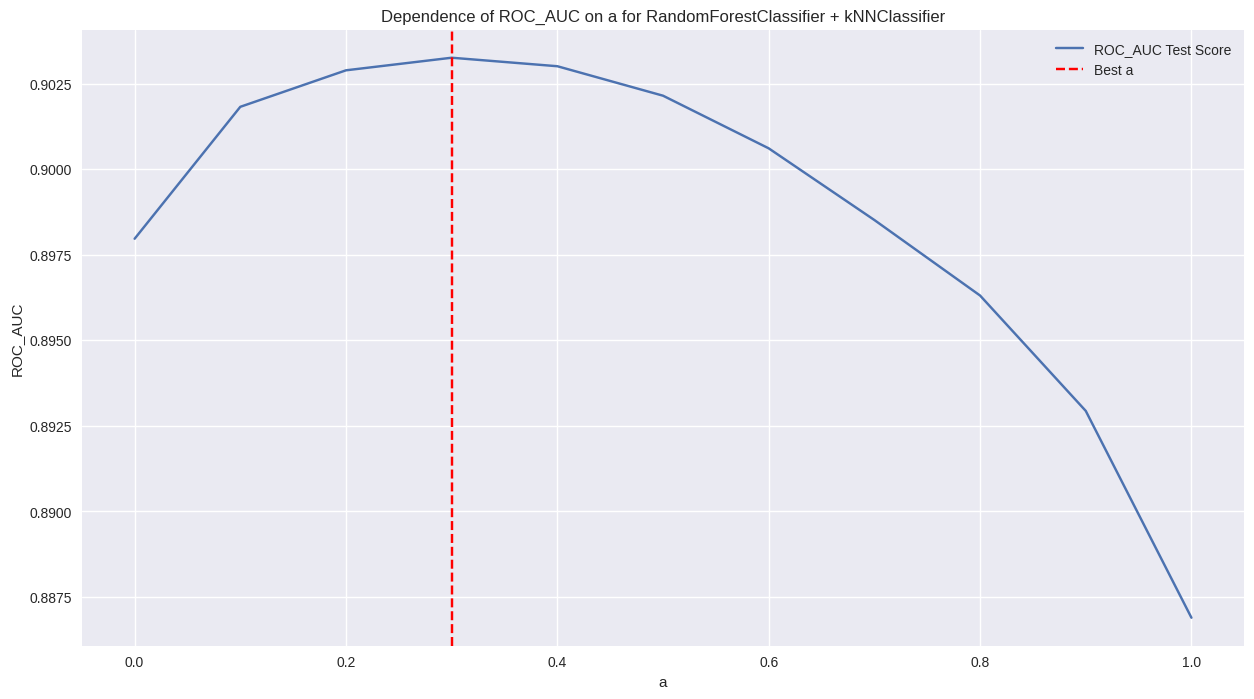

In [ ]:
plt.plot(a_values, roc_auc_list, label='ROC_AUC Test Score')
plt.title("Dependence of ROC_AUC on a for RandomForestClassifier + kNNClassifier")
plt.xlabel("a")
plt.ylabel("ROC_AUC")
plt.axvline(x=a_values[roc_auc_list.index(max(roc_auc_list))], color='r', linestyle='--', label='Best a')
plt.legend()
plt.show()

In [ ]:
print(f'Оптимальное значение а в данном случае равно {a_values[roc_auc_list.index(max(roc_auc_list))]}, качество модели с ним равно {max(roc_auc_list)}.')

Оптимальное значение а в данном случае равно 0.30000000000000004, качество модели с ним равно 0.9032587414913738.


получается очень высокий результат метрики, **0.9032587414913738** это очень много, что говорит о том, что данные два модели очень хорошо дополняют друг другатссввс


## Сравнение построенных моделей

![](http://cdn.shopify.com/s/files/1/0870/1066/files/compare_e8b89647-3cb6-4871-a976-2e36e5987773.png?1750043340268621065)

После того как было построено много моделей хотелось бы сравнить их между собой. Для этого можно построить "ящик с усами" (диаграму размаха). Для этого можно воспользоваться библиотекой [matplotlib](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.boxplot.html) или [seaborn](https://seaborn.pydata.org/generated/seaborn.boxplot.html).

**Задание 13 (1 балл)** Для каждого типа классификатора (kNN, DecisionTree, RandomForest, SGD classifier), а так же смешанной модели выберите тот, которых давал наилучшее качество на кросс-валидации (с учетом подобранных гиперпараметров) и постройте диаграмму размаха (все классификаторы должны быть изображены на одном графике).

Сделайте общие итоговые выводы о классификаторах с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

In [91]:
grid_kNN_class_list = []
grid_DecisonTree_class_list = []
grid_SGD_class_list = []
grid_RandomForest_class_list = []
grid_GradientBoosting_class_list = []

for i in range(5):
    test_split = 'split' + str(i) + '_test_score'
    grid_kNN_class_list.extend(grid_kNN_class.cv_results_[test_split])
    grid_DecisonTree_class_list.extend(grid_DecisionTree_class.cv_results_[test_split])
    grid_SGD_class_list.extend(grid_SGD_class.cv_results_[test_split])
    grid_RandomForest_class_list.extend(grid_RandomForest_class.cv_results_[test_split])
    grid_GradientBoosting_class_list.extend(grid_gradboost.cv_results_[test_split])

grid_RandomForest_kNN_class_list = []
for i in np.arange(1, 11, 2):  # беру те, где а не 0 и не 1
    grid_RandomForest_kNN_class_list.append(roc_auc_list[i])
models = []
models.extend(['grid_kNN_class'] * len(grid_kNN_class_list))
models.extend(['grid_DecisonTree_class'] * len(grid_DecisonTree_class_list))
models.extend(['grid_SGD_class'] * len(grid_SGD_class_list))
models.extend(['grid_RandomForest_class'] * len(grid_RandomForest_class_list))
models.extend(['grid_GradientBoosting_class'] * len(grid_GradientBoosting_class_list))
models.extend(['grid_RandomForest_kNN_class'] * len(grid_RandomForest_kNN_class_list))
roc_auc_results = (
    grid_kNN_class_list +
    grid_DecisonTree_class_list +
    grid_SGD_class_list +
    grid_RandomForest_class_list +
    grid_GradientBoosting_class_list +
    grid_RandomForest_kNN_class_list
)
data_for_graph = pd.DataFrame({
    'roc_auc_results': roc_auc_results,
    'models': models
})

<Axes: xlabel='models', ylabel='roc_auc_results'>

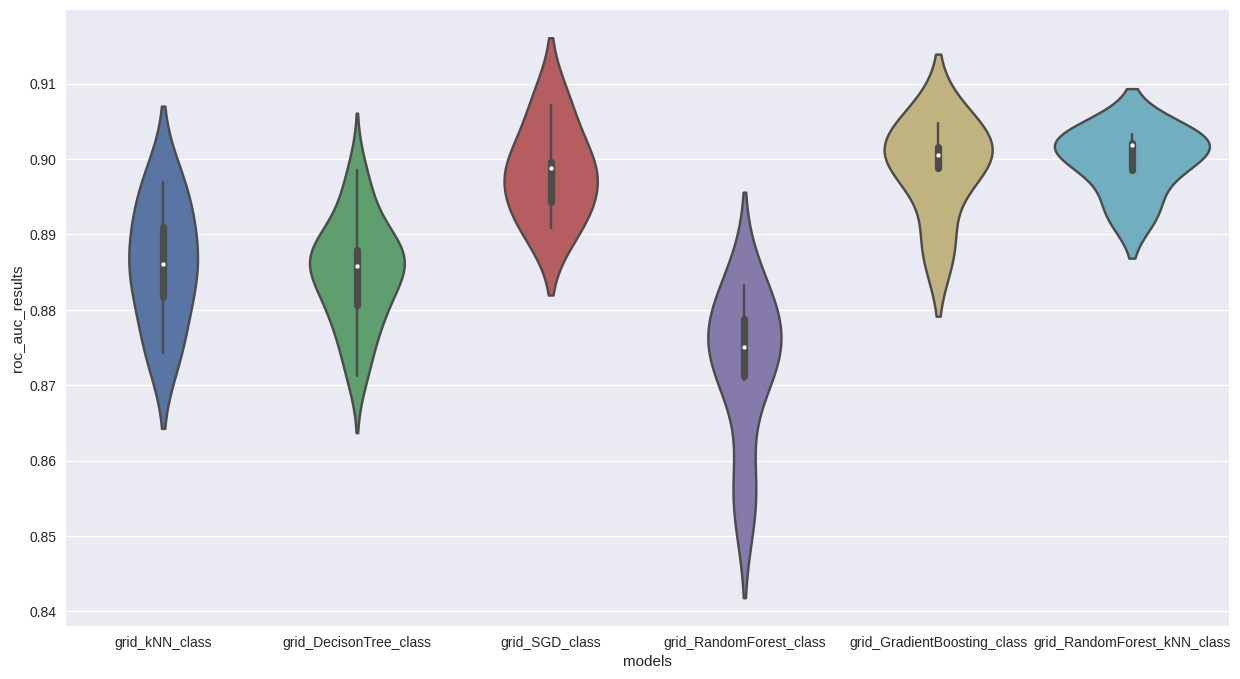

In [92]:
sns.violinplot(x='models', y='roc_auc_results', data=data_for_graph)

**Используемые гиперпараметры для kNN:** {'kNN_class__metric': 'manhattan', 'kNN_class__n_neighbors': 20}


**Используемые гиперпараметры Decision Tree:** {'DecisonTree_class__criterion': 'entropy', 'DecisonTree_class__max_depth': 7}


**Используемые гиперпараметры для SGD:**{'SGD_class__loss': 'log', 'SGD_class__penalty': 'elasticnet'}


**Используемые гиперпараметры для Random Forest:**{'RandomForest_class__criterion': 'entropy', 'RandomForest_class__max_features': 'sqrt', 'RandomForest_class__n_estimators': 44}


**Используемые гиперпараметры для Gradient Boosting:** {'GradientBoosting_class__criterion': 'squared_error', 'GradientBoosting_class__max_features': 'auto', 'GradientBoosting_class__n_estimators': 25}

В целом все модели хорошо справляются, но самые хорошие результаты получаются при добавлении всех признаков в модель
Однако, если ддобавлять поли-признаки и отбирать фичи, то обучение длится крайне долго, что не есть хорошо
Очень удивила смесь моделей, не ожидал, что смешивание покажет значение метрики 0.90